In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

def score_dataset(x_train, x_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=200, random_state=0)
    model.fit(x_train, y_train)
    preds = model.predict(x_valid)
    return mean_absolute_error(y_valid, preds)

# Data loader

In [8]:
df_train = pd.read_csv('input/train.csv')

# Check Null values

In [9]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


# Erase Null values

In [10]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, axis=1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

# Outliers erase

### GrLivArea

1129.0


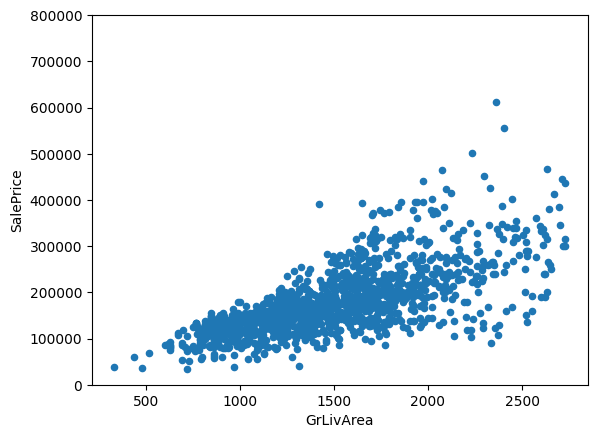

In [11]:
quantiles = df_train.quantile(q=[.25, .75], numeric_only=True)
print(quantiles['GrLivArea'][0.25])

GrLivArea = quantiles['GrLivArea']

df_train = df_train.drop(df_train[(df_train['GrLivArea'] < GrLivArea[0.25] - 1.5*(GrLivArea[0.75] - GrLivArea[0.25])) | (df_train['GrLivArea'] > GrLivArea[0.75] + 1.5*(GrLivArea[0.75] - GrLivArea[0.25]))].index)

df_train.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

### TotalBsmtSF

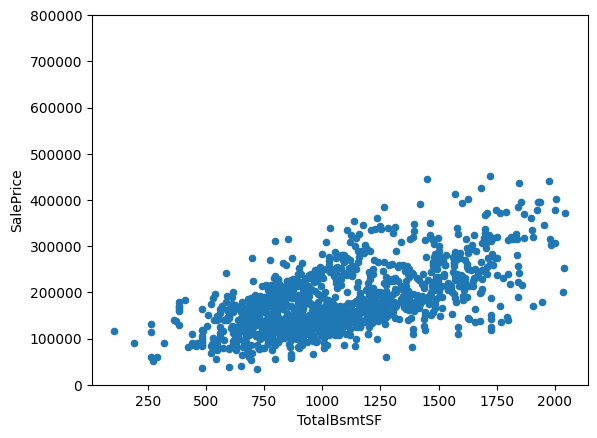

In [12]:
TotalBsmtSF = quantiles['TotalBsmtSF']

df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] < TotalBsmtSF[0.25] - 1.5*(TotalBsmtSF[0.75] - TotalBsmtSF[0.25])) | (df_train['TotalBsmtSF'] > TotalBsmtSF[0.75] + 1.5*(TotalBsmtSF[0.75] - TotalBsmtSF[0.25]))].index)

df_train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

### SalePrice

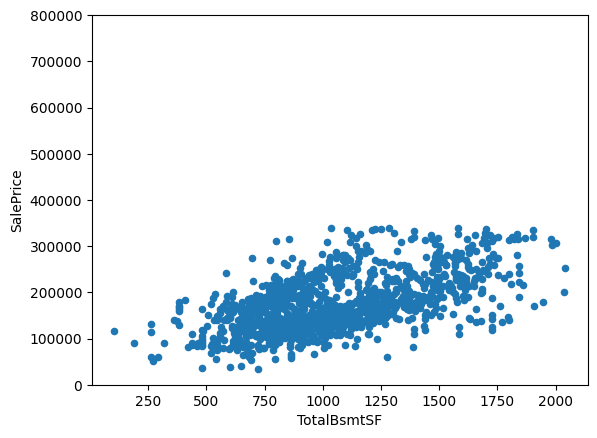

In [13]:
SalePrice = quantiles['SalePrice']

df_train = df_train.drop(df_train[(df_train['SalePrice'] < SalePrice[0.25] - 1.5*(SalePrice[0.75] - SalePrice[0.25])) | (df_train['SalePrice'] > SalePrice[0.75] + 1.5*(SalePrice[0.75] - SalePrice[0.25]))].index)

df_train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

# Model relation between SalePrice and GrLivArea

In [19]:
model1 = ols('SalePrice ~ GrLivArea', data=df_train)
res1 = model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     1227.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          3.27e-191
Time:                        22:26:45   Log-Likelihood:                -16141.
No. Observations:                1338   AIC:                         3.229e+04
Df Residuals:                    1336   BIC:                         3.230e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.502e+04   4039.348      8.669      0.000    2.71e+04    4.29e+04
GrLivArea     93.2614      2.663     35.026      0.000      88.038      98.485
==============================================================================
Omnibus:                       34.871   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.988
Skew:                           0.099   Prob(JB):                     8.58e-17
Kurtosis:                       4.135   Cond. No.                     5.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model relation between SalePrice and OverallQual

In [20]:
model2 = ols('SalePrice ~ OverallQual', data=df_train)
res2 = model2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     2114.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.75e-277
Time:                        22:26:48   Log-Likelihood:                -15942.
No. Observations:                1338   AIC:                         3.189e+04
Df Residuals:                    1336   BIC:                         3.190e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.933e+04   4886.189    -10.095      0.000   -5.89e+04   -3.97e+04
OverallQual  3.662e+04    796.595     45.975      0.000    3.51e+04    3.82e+04
==============================================================================
Omnibus:                       30.634   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.016
Skew:                           0.259   Prob(JB):                     1.24e-09
Kurtosis:                       3.683   Cond. No.                         31.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
model_combined = ols('SalePrice ~ GrLivArea + OverallQual + TotalBsmtSF', data=df_train)
res_combined = model_combined.fit()
res_combined.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     1494.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:27:15   Log-Likelihood:                -15592.
No. Observations:                1338   AIC:                         3.119e+04
Df Residuals:                    1334   BIC:                         3.121e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -8.209e+04   3926.191    -20.909      0.000   -8.98e+04   -7.44e+04
GrLivArea      47.3169      2.106     22.463      0.000      43.185      51.449
OverallQual  2.281e+04    764.930     29.819      0.000    2.13e+04    2.43e+04
TotalBsmtSF    45.2500      2.560     17.673      0.000      40.227      50.273
==============================================================================
Omnibus:                       61.080   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.337
Skew:                          -0.308   Prob(JB):                     4.49e-27
Kurtosis:                       4.340   Cond. No.                     9.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""